# <ins> Análisis de datos de accidentes viales </ins>

## 1- Importando el dataset

### _Se importa el dataset con Pandas y se definen los nombres de las columnas, para poder referenciarlas posteriormente._

In [1]:
%matplotlib inline
import pandas as pd
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

pd.set_option('display.max_columns', None)

#Importamos solamente los atributos que nos interesa analizar.
data_frame = pd.read_csv("Accidente.csv", header=0 ,usecols=["Severity","Junction", "Stop", "Traffic_Signal", "Side", "Temperature(F)",
 "Sunrise_Sunset","Visibility(mi)", "Pressure(in)","Humidity(%)","Wind_Speed(mph)", "Distance(mi)", "Crossing", "Railway", "Start_Time", "Weather_Condition"])

#Definimos la semilla que se utilizará a lo largo del proyecto.
random_state=15

## 2- Data Processing.

### _2.1. Se eliminan todos los duplicados, seaplica One-Hot-Encoding para tratar los datos categóricos de forma adecuada para los modelos y se convierten todos los booleanos a 0 y 1._

In [2]:
data_frame.drop_duplicates(inplace=True)

#Reemplazamos todos los True y False por 1 y 0, respectivamente. Esto aplica a las columnas Junction, Stop, Crossing Railway y Traffic_Signal
data_frame = data_frame.replace([True, False], [1, 0])

#Columna "Sunrise_Sunset"
data_frame_dummies_sunrise_sunset = pd.get_dummies(data_frame['Sunrise_Sunset'])
data_frame_dummies_sunrise_sunset = data_frame_dummies_sunrise_sunset.rename(columns=lambda s: "Sunrise_Sunset_" + s)
data_frame = data_frame.drop(['Sunrise_Sunset'], axis = 1)
data_frame = data_frame.join(data_frame_dummies_sunrise_sunset)

#Columna "Side"
data_frame_dummies_side = pd.get_dummies(data_frame['Side'])
data_frame_dummies_side = data_frame_dummies_side.rename(columns=lambda s: "Side_" + s)
data_frame = data_frame.drop(['Side'], axis = 1)
data_frame = data_frame.join(data_frame_dummies_side)

data_frame.head(5)

,Severity,Start_Time,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Weather_Condition,Crossing,Junction,Railway,Stop,Traffic_Signal,Sunrise_Sunset_Day,Sunrise_Sunset_Night,Side_,Side_L,Side_R
0,3,2016-02-08 05:46:00,0.01,36.9,91.0,29.68,10.0,NaN,Light Rain,0,0,0,0,0,0,1,0,0,1
1,2,2016-02-08 06:07:59,0.01,37.9,100.0,29.65,10.0,NaN,Light Rain,0,0,0,0,0,0,1,0,1,0
2,2,2016-02-08 06:49:27,0.01,36.0,100.0,29.67,10.0,3.5,Overcast,0,0,0,0,1,0,1,0,0,1
3,3,2016-02-08 07:23:34,0.01,35.1,96.0,29.64,9.0,4.6,Mostly Cloudy,0,0,0,0,0,0,1,0,0,1
4,2,2016-02-08 07:39:07,0.01,36.0,89.0,29.65,6.0,3.5,Mostly Cloudy,0,0,0,0,1,1,0,0,0,1


### _2.2. Acotamos los valores de condiciones climáticas y aplicamos one-hot-encoding sobre "Weather\_Condition"._

In [3]:
data_frame.loc[data_frame["Weather_Condition"].str.contains("Thunder|T-Storm", na=False), "Weather_Condition"] = "Tormenta"
data_frame.loc[data_frame["Weather_Condition"].str.contains("Snow|Sleet|Wintry", na=False), "Weather_Condition"] = "Nieve"
data_frame.loc[data_frame["Weather_Condition"].str.contains("Rain|Drizzle|Shower", na=False), "Weather_Condition"] = "Lluvia"
data_frame.loc[data_frame["Weather_Condition"].str.contains("Wind|Squalls", na=False), "Weather_Condition"] = "Ventoso"
data_frame.loc[data_frame["Weather_Condition"].str.contains("Hail|Pellets", na=False), "Weather_Condition"] = "Granizada"
data_frame.loc[data_frame["Weather_Condition"].str.contains("Fair", na=False), "Weather_Condition"] = "Despejado"
data_frame.loc[data_frame["Weather_Condition"].str.contains("Cloud|Overcast", na=False), "Weather_Condition"] = "Nublado"
data_frame.loc[data_frame["Weather_Condition"].str.contains("Mist|Haze|Fog", na=False), "Weather_Condition"] = "Niebla"
data_frame.loc[data_frame["Weather_Condition"].str.contains("Sand|Dust", na=False), "Weather_Condition"] = "Tormenta de arena"
data_frame.loc[data_frame["Weather_Condition"].str.contains("Smoke|Volcanic Ash", na=False), "Weather_Condition"] = "Humo"
data_frame.loc[data_frame["Weather_Condition"].str.contains("N/A Precipitation", na=False), "Weather_Condition"] = np.nan

print(data_frame["Weather_Condition"].unique())

#Columna "Weather_Condition"
data_frame_dummies_weather_condition = pd.get_dummies(data_frame['Weather_Condition'])
data_frame_dummies_weather_condition = data_frame_dummies_weather_condition.rename(columns=lambda s: "Weather_Condition" + s)
data_frame = data_frame.drop(['Weather_Condition'], axis = 1)
data_frame = data_frame.join(data_frame_dummies_weather_condition)

['Lluvia' 'Nublado' 'Nieve' 'Niebla' 'Clear' nan 'Humo' 'Tormenta'
 'Despejado' 'Tormenta de arena' 'Ventoso' 'Granizada' 'Tornado']


### _2.3. Subdividimos la fecha del accidente y eliminamos la característica original._

In [4]:
data_frame["Start_Time"] = pd.to_datetime(data_frame["Start_Time"])

# Extract year, month, weekday and day
data_frame["Year"] = data_frame["Start_Time"].dt.year
data_frame["Month"] = data_frame["Start_Time"].dt.month
data_frame["Weekday"] = data_frame["Start_Time"].dt.weekday
data_frame["Day"] = data_frame["Start_Time"].dt.day

# Extract hour and minute
data_frame["Hour"] = data_frame["Start_Time"].dt.hour
data_frame["Minute"] = data_frame["Start_Time"].dt.minute

data_frame.drop("Start_Time",axis=1, inplace=True)


### _2.4. Se verifican los valores de Presión y Visibilidad._
#### _Como estos poseen valores incoherentes, se eliminan todas las instancias en que valen 0._

In [5]:
#Verificamos los valores de Presión y Visibilidad
data_frame[["Pressure(in)", "Visibility(mi)"]].describe().round(2)

"""Tras ver el resultado, y considerando que es imposible una visibilidad de 0 millas y
   una presión de 0 pulgadas, procedemos a eliminar estos posibles valores del dataset."""

data_frame = data_frame[data_frame["Pressure(in)"] != 0]
data_frame = data_frame[data_frame["Visibility(mi)"] != 0]
data_frame[["Pressure(in)", "Visibility(mi)"]].describe().round(2)

,Pressure(in),Visibility(mi)
count,2896513.00,2879133.00
mean,29.83,9.15
std,0.71,2.89
min,0.02,0.06
25%,29.82,10.00
50%,29.98,10.00
75%,30.11,10.00
max,33.04,140.00


### _2.5. Se completan todos los datos faltantes de Visibilidad, Presión, Humedad, Temperatura y Velocidad del Viento con la media de cada característica._
#### _Esto se hace dado que de otra forma deberían eliminarse las filas, y representaría perder una gran cantidad de datos, que como se verá posteriormente, por tener tan pocas instancias de accidentes con Severidad 1, afectaría de forma negativa a la aplicación de los modelos._

In [6]:
#Rellenamos valores nulos con la media:

params = ["Visibility(mi)", "Pressure(in)", "Humidity(%)", "Temperature(F)", "Wind_Speed(mph)"]

data_frame[params] = data_frame[params].fillna(data_frame[params].mean())

data_frame.dropna(inplace=True)

### _2.6. Se realiza una matriz de correlación para ver claramente qué características son más útiles para predecir la severidad de un accidente, y cuáles no tienen una fuerte relación con esta característica._

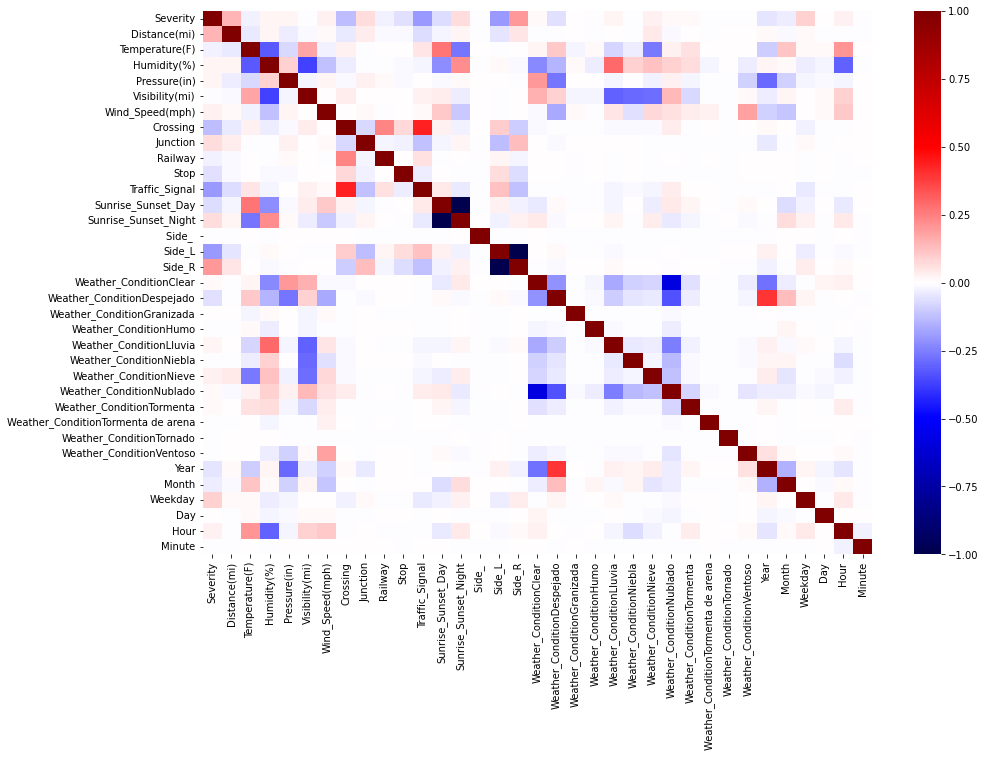

In [7]:
correlation_matrix = data_frame.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, vmin=-1, vmax=1, cmap="seismic")
plt.gca().patch.set(hatch="X", edgecolor="#666")
plt.show()

### _2.7. Eliminamos las características que tienen muy baja correlación con la severidad._

In [8]:
data_frame.drop("Crossing",axis=1, inplace=True)
data_frame.drop("Side_L",axis=1, inplace=True)
data_frame.drop("Traffic_Signal",axis=1, inplace=True)

### _2.8. Se reemplaza el dataset por una muestra en que se almacena la misma cantidad de datos de cada tipo de severidad. El tamaño de esta muestra está dado por la cantidad de ocurrencias de Severity = 1, que es la clase que aparece la menor cantidad de veces._

In [9]:
#Toma la cantidad de datos de severidad 1 (la clase con menos instancias de todas)
size = len(data_frame[data_frame["Severity"]==1].index)
df = pd.DataFrame()
for i in range(1,5):
    #Selecciona el tipo de severidad
    sev = data_frame[data_frame["Severity"]==i]
    #Toma una muestra de tamaño "size" de la severidad seleccionada
    df = df.append(sev.sample(size, random_state=random_state))

data_frame = df

data_frame.reset_index(inplace=True)

### _2.9. Se escalan las variables continuas, para disminuir lo más posible el impacto que puedan tener los outliers sobre los modelos aplicados posteriormente._
#### _Se aplica el algoritmo MinMaxScaler, elegido por ser el scaler que mejor performance dio posteriormente al entrenar los modelos. En una primera instancia, se probaron los scalers MinMax, Robust y Standard._

In [10]:
minMaxScaler = MinMaxScaler()
data_min_max_scaler = minMaxScaler.fit_transform(data_frame[["Humidity(%)", "Pressure(in)", "Wind_Speed(mph)", "Distance(mi)", "Visibility(mi)", "Temperature(F)"]])
data_min_max_scaler = pd.DataFrame(data_min_max_scaler, columns =["Humidity(%)", "Pressure(in)", "Wind_Speed(mph)", "Distance(mi)", "Visibility(mi)", "Temperature(F)"])

data_frame = data_frame.drop(["Humidity(%)", "Pressure(in)", "Wind_Speed(mph)", "Distance(mi)", "Visibility(mi)", "Temperature(F)"], axis = 1)
data_frame = data_frame.join(data_min_max_scaler)

## 3- Aplicación de Modelos - Linear SVC.

### _3.1- Se toman todos los datos que quedaron en el dataset luego de haber tomado una muestra con la misma cantidad de ocurrencias de cada tipo de severidad en los pasos anteriores._
#### _En total se cuenta con 3868 datos._

In [11]:
sample = data_frame.sample(3_000, random_state=random_state)
y_sample = sample["Severity"]
x_sample = sample.drop("Severity", axis=1)

print(y_sample.value_counts())
print("-"*50)
print(x_sample.count())

1    967
2    967
3    967
4    967
Name: Severity, dtype: int64
--------------------------------------------------
index                                 3868
Junction                              3868
Railway                               3868
Stop                                  3868
Sunrise_Sunset_Day                    3868
Sunrise_Sunset_Night                  3868
Side_                                 3868
Side_R                                3868
Weather_ConditionClear                3868
Weather_ConditionDespejado            3868
Weather_ConditionGranizada            3868
Weather_ConditionHumo                 3868
Weather_ConditionLluvia               3868
Weather_ConditionNiebla               3868
Weather_ConditionNieve                3868
Weather_ConditionNublado              3868
Weather_ConditionTormenta             3868
Weather_ConditionTormenta de arena    3868
Weather_ConditionTornado              3868
Weather_ConditionVentoso              3868
Year                    

### _3.2- Se aplica Grid Search para conseguir el parámetro de C que mejor ajusta al modelo._

In [12]:
"""parameters = {'C': [0.1, 0.2, 0.5],'kernel': ['linear']}
#parameters = [{"kernel": ["linear", "rbf", "sigmoid"], "C": [.2, .5, .8, 1.]}, {"kernel": ["poly"], "C": [.2, .5, .8, 1.], "degree": [2, 3, 4]}]
modelSVC = svm.SVC(random_state=random_state)

grid = GridSearchCV(modelSVC, parameters, n_jobs=-1)

grid.fit(x_sample, y_sample)

print("Mejor valor de C:")
print(grid.best_params_)
print("Train score:", grid.score(x_sample, y_sample))"""

'parameters = {\'C\': [0.1, 0.2, 0.5],\'kernel\': [\'linear\']}\n#parameters = [{"kernel": ["linear", "rbf", "sigmoid"], "C": [.2, .5, .8, 1.]}, {"kernel": ["poly"], "C": [.2, .5, .8, 1.], "degree": [2, 3, 4]}]\nmodelSVC = svm.SVC(random_state=random_state)\n\ngrid = GridSearchCV(modelSVC, parameters, n_jobs=-1)\n\ngrid.fit(x_sample, y_sample)\n\nprint("Mejor valor de C:")\nprint(grid.best_params_)\nprint("Train score:", grid.score(x_sample, y_sample))'

### _3.3- Una vez conseguido el mejor valor de C, se lo utiliza para entrenar al modelo con el mismo._

In [13]:
xtrain, xtest, ytrain, ytest = train_test_split(x_sample, y_sample, stratify=y_sample, test_size=0.2, random_state=random_state)

#linear_svc = svm.SVC(**grid.best_params_,random_state=random_state)
linear_svc = svm.SVC(C=0.2,gamma= 0.1,kernel="linear",random_state=random_state)

linear_svc.fit(xtrain, ytrain)

print("Train score:", linear_svc.score(xtrain, ytrain))
print("Test score:", linear_svc.score(xtest, ytest))
print("YTRAIN MAX: {}".format(np.max(ytrain)))
print("YTRAIN MIN: {}".format(np.min(ytrain)))
print("YTEST MAX: {}".format(np.max(ytest)))
print("YTEST MIN: {}".format(np.min(ytest)))


### _3.4- Se predicen los resultados de Severity de acuerdo a los datos de testing, y se proyecta su resultado en una matriz de confusión._

YPRED MAX: 4
YPRED MIN: 1
YTRAIN MAX: 4
YTRAIN MIN: 1
YTEST MAX: 4
YTEST MIN: 1


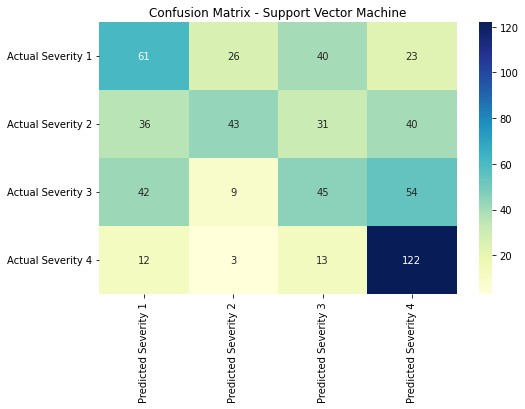

2    150
3    150
4    150
1    150
Name: Severity, dtype: int64


In [ ]:
y_pred = linear_svc.predict(xtest)
confmat = confusion_matrix(y_true=ytest, y_pred=y_pred)

print("YPRED MAX: {}".format(np.max(y_pred)))
print("YPRED MIN: {}".format(np.min(y_pred)))
print("YTRAIN MAX: {}".format(np.max(ytrain)))
print("YTRAIN MIN: {}".format(np.min(ytrain)))
print("YTEST MAX: {}".format(np.max(ytest)))
print("YTEST MIN: {}".format(np.min(ytest)))

index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]
conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - Support Vector Machine")
plt.show()
print(ytest.value_counts())